In [2]:
# imports
import rosbags_converter as rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seatrac_enums import CST_E
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress

In [3]:
# User Variables

vehicle = '/coug2'
ROSBAGS_DIR = "/home/bjm255/couguv/CoUGARs/bag" + vehicle 
ROSBAGS_DIR = "/home/bjm255/couguv/CoUGARs/bag" + '/sim' 
SAVES_DIR = "coug2"

MISSION_KEYWORDS = ["Heading", "6.0"]

VERBOSE=True

In [4]:
# Convert Rosbags
dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS, verbose=True)
if len(dataframes)==0:
    print("converting rosbags")
    typestore = rc.generate_typestore("../../cougars-ros2/src")
    dataframes = rc.convert_rosbags(ROSBAGS_DIR, typestore, 
                                    keywords=MISSION_KEYWORDS,verbose=VERBOSE)
    rc.save_to_csv(dataframes, SAVES_DIR, verbose=VERBOSE)
    dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS)

Loading /home/bjm255/couguv/CoUGARs/cougars-base-station/postprocessing/coug2/converted__Heading_response_faster2.0-2025-05-13-12-28-22
Loading /home/bjm255/couguv/CoUGARs/cougars-base-station/postprocessing/coug2/converted__6.0_SO-2025-05-02-12-11-09


In [5]:
# display topics by rosbag
for path, topics in dataframes.items():
    print(f"{path}:\n\t{list(topics.keys())}")

converted__Heading_response_faster2.0-2025-05-13-12-28-22:
	['/coug2/desired_depth', '/holoocean/auv0/DepthSensor', '/coug2/depth_data', '/clock', '/coug2/dvl/data', '/tf_static', '/holoocean/auv0/DynamicsSensorOdom', '/coug2/desired_heading', '/holoocean/auv0/GPSSensor', '/coug2/controls/debug', '/coug2/desired_speed', '/coug2/extended_fix', '/holoocean/auv0/DVLSensorVelocity', '/holoocean/auv0/LocationSensor', '/coug2/gps_odom', '/coug2/pressure/data', '/coug2/controls/command', '/coug2/modem_imu', '/holoocean/auv0/RotationSensor', '/holoocean/auv0/DynamicsSensorIMU', '/holoocean/auv0/IMUSensor']
converted__6.0_SO-2025-05-02-12-11-09:
	['/coug2/desired_depth', '/coug2/depth_data', '/tf', '/tf_static', '/coug2/safety_status', '/coug2/fix', '/coug2/battery/data', '/coug2/desired_heading', '/coug2/kinematics/command', '/coug2/controls/debug', '/coug2/system/status', '/coug2/desired_speed', '/coug2/extended_fix', '/coug2/gps_odom', '/coug2/pressure/data', '/coug2/odom', '/coug2/controls/

In [6]:
# lists dataframes by topic. 
# Assumes all vehicles have only one loaded mission and different namespaces
# Check previous cell output to confirm this is the case
# dfsByTopic = {}

# for topic_dfs in dataframes.values(): dfsByTopic.update(topic_dfs)
# print(list(dfsByTopic.keys()))

In [7]:
# Get only the first dataframe
sim_data, sim_topics = next(iter(dataframes.items()))

print(f"{sim_data}:\n\t{list(sim_topics.keys())}")

# Get the second dataframe
rw_data, rw_topics = list(dataframes.items())[1]

print(f"{rw_data}:\n\t{list(rw_topics.keys())}")

converted__Heading_response_faster2.0-2025-05-13-12-28-22:
	['/coug2/desired_depth', '/holoocean/auv0/DepthSensor', '/coug2/depth_data', '/clock', '/coug2/dvl/data', '/tf_static', '/holoocean/auv0/DynamicsSensorOdom', '/coug2/desired_heading', '/holoocean/auv0/GPSSensor', '/coug2/controls/debug', '/coug2/desired_speed', '/coug2/extended_fix', '/holoocean/auv0/DVLSensorVelocity', '/holoocean/auv0/LocationSensor', '/coug2/gps_odom', '/coug2/pressure/data', '/coug2/controls/command', '/coug2/modem_imu', '/holoocean/auv0/RotationSensor', '/holoocean/auv0/DynamicsSensorIMU', '/holoocean/auv0/IMUSensor']
converted__6.0_SO-2025-05-02-12-11-09:
	['/coug2/desired_depth', '/coug2/depth_data', '/tf', '/tf_static', '/coug2/safety_status', '/coug2/fix', '/coug2/battery/data', '/coug2/desired_heading', '/coug2/kinematics/command', '/coug2/controls/debug', '/coug2/system/status', '/coug2/desired_speed', '/coug2/extended_fix', '/coug2/gps_odom', '/coug2/pressure/data', '/coug2/odom', '/coug2/controls/

In [8]:
# Display a dataframe
print(f"DataFrame example:")
sampleDf = rw_topics[vehicle + "/controls/debug"]
print(sampleDf.iloc[:5])
print("...")

DataFrame example:
   header.stamp.sec  header.stamp.nanosec  header.frame_id  depth.actual  \
0        1746209470             815444722              NaN      0.009054   
1        1746209470             895368810              NaN      0.007827   
2        1746209470             975448174              NaN      0.008440   
3        1746209471              55385187              NaN      0.012325   
4        1746209471             135362756              NaN      0.012325   

   depth.rate  depth.desired  depth.reference   depth.p  depth.i  depth.d  \
0         0.0            0.0         0.034824  0.515414      0.0      0.0   
1         0.0            0.0         0.033999  0.523436      0.0      0.0   
2         0.0            0.0         0.033192  0.495042      0.0      0.0   
3         0.0            0.0         0.032405  0.401594      0.0      0.0   
4         0.0            0.0         0.031637  0.386225      0.0      0.0   

   ...  pitch.d  pitch.pid  heading.actual  heading.rate  hea

In [9]:
# convert ros timestamps to pandas timestamps

for df in sim_topics.values():
    if "header.stamp.sec" in df.columns: 
        df["timestamp"] = pd.to_datetime(
            df["header.stamp.sec"] * 1_000_000_000 
            + df["header.stamp.nanosec"], unit='ns'
        )

sim_timestamps = sim_topics[vehicle + "/desired_depth"]["timestamp"]
print(f"RosBag timeframe:\t{sim_timestamps.min()} --- {sim_timestamps.max()}")

for df in rw_topics.values():
    if "header.stamp.sec" in df.columns: 
        df["timestamp"] = pd.to_datetime(
            df["header.stamp.sec"] * 1_000_000_000 
            + df["header.stamp.nanosec"], unit='ns'
        )

rw_timestamps = rw_topics[vehicle + "/desired_depth"]["timestamp"]
print(f"RosBag timeframe:\t{rw_timestamps.min()} --- {rw_timestamps.max()}")

RosBag timeframe:	2025-05-13 18:28:25.030720759 --- 2025-05-13 18:29:32.530266690
RosBag timeframe:	2025-05-02 18:11:10.481785172 --- 2025-05-02 18:16:40.481774617


/tmp/ipykernel_588599/141417832.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_rw_df["time_sec"] = (cropped_rw_df["timestamp"] - start_time).dt.total_seconds()
/tmp/ipykernel_588599/141417832.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()


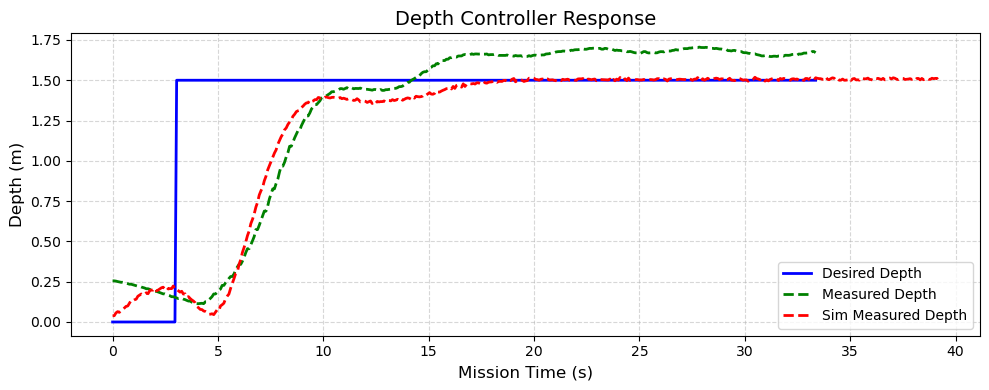

In [14]:

rw_controls_debug = rw_topics[vehicle + "/controls/debug"]
cropped_rw_df = rw_controls_debug.iloc[83:501]

sim_controls_debug = sim_topics[vehicle + "/controls/debug"]
cropped_sim_df = sim_controls_debug.iloc[10:501]

# Convert timestamp to seconds since mission start
start_time = cropped_rw_df["timestamp"].iloc[0]
cropped_rw_df["time_sec"] = (cropped_rw_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_rw_df["time_sec"].to_numpy()
y1 = cropped_rw_df["depth.desired"].to_numpy()
y2 = cropped_rw_df["depth.actual"].to_numpy()


# Convert timestamp to seconds since mission start
start_time = cropped_sim_df["timestamp"].iloc[0]
cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x_sim = cropped_sim_df["time_sec"].to_numpy()
y_sim1 = cropped_sim_df["depth.desired"].to_numpy()
y_sim2 = cropped_sim_df["depth.actual"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x, y1, label='Desired Depth', color='blue', linewidth=2)
ax.plot(x, y2, label='Measured Depth', color='green', linewidth=2, linestyle='--')
# ax.plot(x_sim, y_sim1, label='Depth Sim Desired', color='purple', linewidth=2)
ax.plot(x_sim, y_sim2, label='Sim Measured Depth', color='red', linewidth=2, linestyle='--')
# ax.plot(x, y3, label='Depth Reference', color='red', linewidth=2, linestyle='--')

# Labels and formatting
ax.set_title('Depth Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipykernel_588599/3332835872.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_rw_df["time_sec"] = (cropped_rw_df["timestamp"] - start_time).dt.total_seconds()
/tmp/ipykernel_588599/3332835872.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()


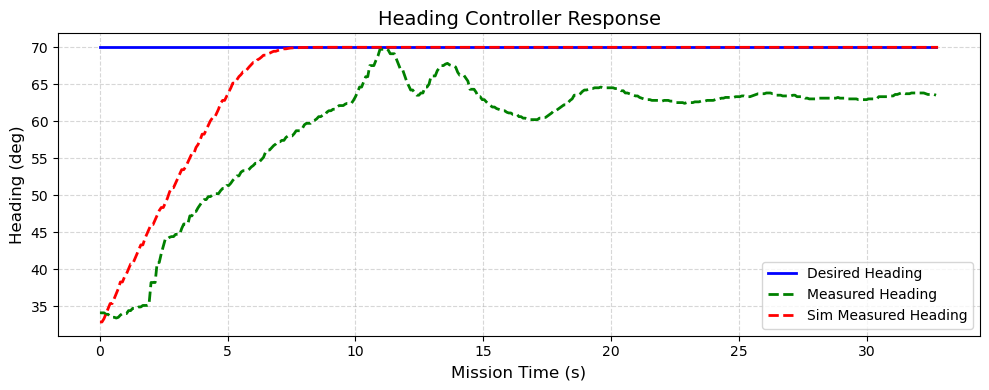

In [28]:

rw_controls_debug = rw_topics[vehicle + "/controls/debug"]
cropped_rw_df = rw_controls_debug.iloc[0:410]

sim_controls_debug = sim_topics[vehicle + "/controls/debug"]
cropped_sim_df = sim_controls_debug.iloc[90:501]

# Convert timestamp to seconds since mission start
start_time = cropped_rw_df["timestamp"].iloc[0]
cropped_rw_df["time_sec"] = (cropped_rw_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_rw_df["time_sec"].to_numpy()
y1 = cropped_rw_df["heading.desired"].to_numpy()
y2 = cropped_rw_df["heading.actual"].to_numpy()


start_time = cropped_sim_df["timestamp"].iloc[0]
cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x_sim = cropped_sim_df["time_sec"].to_numpy()
y_sim1 = cropped_sim_df["heading.desired"].to_numpy()
y_sim2 = cropped_sim_df["heading.actual"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x, y1, label='Desired Heading', color='blue', linewidth=2)
ax.plot(x, y2, label='Measured Heading', color='green', linewidth=2, linestyle='--')

ax.plot(x_sim, y_sim2, label='Sim Measured Heading', color='red', linewidth=2, linestyle='--')
# ax.plot(x_sim, y_sim1, label='Sim Desired Depth', color='red', linewidth=2, linestyle='--')

# Labels and formatting
ax.set_title('Heading Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Heading (deg)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()
